In [123]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np

In [124]:
mmHg=0.00075

# Oscillating flow in a bifurcation

### Graph representation

We consider a network of 3 channels connected in one node. It is represented by the graph of 4 nodes $\{0,1,2,3\}$ and 3 edges $\{(0,1),(1,2),(1,3)\}$.

In this graph there is one internal vertex $N_i=\{1\}$ and 3 external vertex $N_2=\{0,2,3\}$ where we will impose the boundary conditions.

#### Parameters

In [125]:
rho=1
cf=12 # Hollow cylinder case
n=2
nu=7e-3

T=1
w=2*np.pi/T

In [175]:
nodes=[0,1,2,3]
edges=[(0,1),(1,2),(1,3)]
internal_nodes=[1]
external_nodes=[0,2,3]

lengths=np.array([1,1,1])*500e-4
amps=np.array([0.01,0.01,0.01])
radius=np.array([20e-4,10e-4,10e-4])
apertures=np.array([10e-4,10e-4,10e-4])
areas=2*np.pi*radius*apertures

In [176]:
## With only 2 edges
#nodes=[0,1,2]
#edges=[(0,1),(1,2)]
#internal_nodes=[1]
#external_nodes=[0,2]

#lengths=np.array([1,1])*500e-4
#amps=np.array([0.01,0.01])
#radius=np.array([20e-4,20e-4])
#apertures=np.array([10e-4,10e-4])
#areas=2*np.pi*radius*apertures

In [177]:
M=len(edges)
N=len(nodes)
Ni=len(internal_nodes)
Ne=len(external_nodes)

## Equations

The set of equations can be represented in a matrix form $G X= S$. With $X$ the unknomn vector made of the $2M+N$ flow and pressure coefficients 
$$
X=(... q_{ij,i},  q_{ij,j} ... , p_1, ... p_i, p_j, ..., p_N)
$$

For our bifurcation, $X$ is of size 10 and reads
$$
X=(q_{01,0} ,  q_{01,1}, q_{12,1} ,  q_{12,2}, q_{13,1} ,  q_{13,3} , p_0, p_1 , p_2,p_3)
$$

The matrices $G$ and $S$ are made from 4 blocks representing the conservation equations. Let fill them step by step.

In [178]:
G=np.zeros([2*M+N,2*M+N],dtype = 'complex_')
S=np.zeros(2*M+N,dtype = 'complex_')

The first $M$ rows, represent the flow change along the vessels. 

$$
   \begin{aligned}
       q_{ij,j} -q_{ij,i}&=\Delta q_{ij}\\
   \end{aligned}
$$

with

$$
\begin{aligned}
    \Delta q_{ij} &=  - i n\omega \ell_{ij}
    \bar{A}_{ij}  a_{ij}
\end{aligned}
$$

In [179]:
for e,(i,j) in enumerate(edges) :
    G[e,2*e]=-1
    G[e,2*e+1]=1
    S[e]=-1j*n*w*amps[e]*lengths[e]*areas[e]

The next $M$ rows, represent the pressure change along the vessels. 

$$
   \begin{aligned}
       p_{j} - p_{i}&=  \Delta p ^{a}_{ij} q_{ij,i} + \Delta p ^{b}_{ij}
   \end{aligned}
$$

with

$$
\begin{aligned}
    \Delta p ^{a}_{ij} &=- \frac{c_f\nu \rho }{\bar h_{ij} ^2\bar A_{ij}}\ell_{ij}  -   i \omega  \frac{\rho }{\bar A_{ij}}\ell_{ij} \\
    \Delta p ^{b}_{ij} &= - n\omega ^2 a_{ij}\rho \frac{\ell_{ij} ^2}{2} + i \omega  n a_{ij}\frac{ c_f\nu\rho}{\bar h_{ij}^2}\frac{ \ell_{ij} ^2}{2}\\
\end{aligned}
$$

In [180]:
for e,(i,j) in enumerate(edges) :
    G[M+e,2*M+j]=1
    G[M+e,2*M+i]=-1
    
    deltaPb=-n * amps[e] * w**2 * rho  * lengths[e]**2 / 2  + 1j * w * n * amps[e] * (cf * nu * rho / apertures[e]**2) * lengths[e]**2 / 2
    deltaPa=- cf * nu * rho / apertures[e]**2 / areas[e] * lengths[e] - 1j * w * rho / areas[e] * lengths[e]
    
    G[M+e,2*e]=-deltaPa
    S[M+e]=deltaPb    

The following $N_i=1$ lines represent the mass conservation at junctions

In [181]:
for ni,junction in enumerate(internal_nodes) :
    
    print('junction node', junction)
    
    # Because the graph is small in this exemple we can scan all the edges to check the adjacency with the vertex. 
    # In a more complex network we would use a proper graph library to assess vertice degree and adjacent edges.
    
    for e, (i,j) in enumerate(edges) :
        if i==junction :
            G[2*M+ni,2*e]=-1
        elif j==junction :
            G[2*M+ni,2*e+1]=1

junction node 1


The last $N_e=3$ lines are used to impose the boundary conditions. We impose a zero flow on node $0$ and zero pressure on nodes 2 and 3. 

In [182]:
bc_types=['flow','pressure','pressure']
bc_coefficients=[0,0,0]

for ne,(bc_node, bc_type, bc_coeff) in enumerate(zip(external_nodes, bc_types, bc_coefficients)) :
    

    if bc_type == 'pressure' :
        G[2*M+Ni+ne,2*M+bc_node]=1
        S[2*M+Ni+ne]=bc_coeff
        
    else : #bc_type = 'flow'
    
        # Because the graph is small in this exemple we can scan all the edges to check the adjacency with the vertex. 
        # In a more complex network we would use a proper graph library to assess vertice degree and adjacent edges.

        for e, (i,j) in enumerate(edges) :
            if i==bc_node :
                G[2*M+Ni+ne,2*e]=1
                S[2*M+Ni+ne]=bc_coeff
            elif j==bc_node :
                G[2*M+Ni+ne,2*e+1]=1
                S[2*M+Ni+ne]=bc_coeff
                

## Solve the equations

In [213]:

X = np.zeros([2*M+N] ,dtype = "complex_" )

start_time = time.time()
X=np.linalg.solve(G, np.real(S)) + 1.j*np.linalg.solve(G, np.imag(S))


In [215]:
import scipy.sparse.linalg
import scipy.sparse

Gs=scipy.sparse.csr_matrix(G ,dtype=np.cfloat)

X = scipy.sparse.linalg.spsolve(Gs,S)


## Visualize results

#### Flow spacial profiles

In [216]:
q01_0,q01_1,q12_1,q12_2,q13_1,q13_3, p0,p1,p2,p3=X


#2 edges test
#q01_0,q01_1,q12_1,q12_2, p0,p1,p2=X


In [217]:
#arbitrary absisse to visualize the flow
x=[0,1,1,2]

# flow branch 1 : (0,1),  (1,2)

F1=np.array([q01_0,q01_1,q12_1,q12_2])


# flow branch 2 : (0,1),  (1,3)

F2=np.array([q01_0,q01_1,q13_1,q13_3])

# total flow : (0,1) , (1,2) + (1,3)

Ftot=np.array([q01_0,q01_1,q12_1+q13_1,q12_2+q13_3])


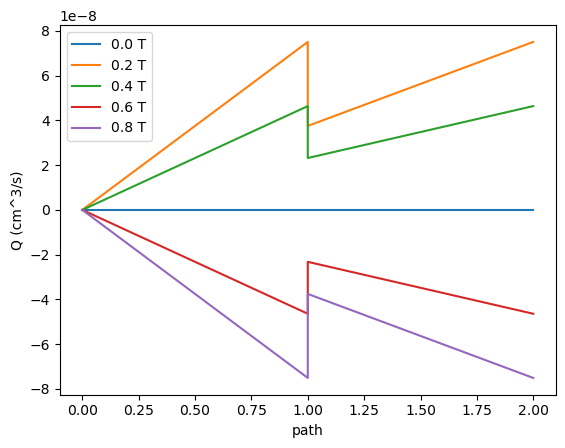

In [218]:
for t in np.arange(0,1,0.2)*T :
    plt.plot(x,np.real(F1*np.exp(1j*w*t)),label='%.1f T'%(t/T))
    
plt.xlabel('path')
plt.ylabel('Q (cm^3/s)')

plt.legend()

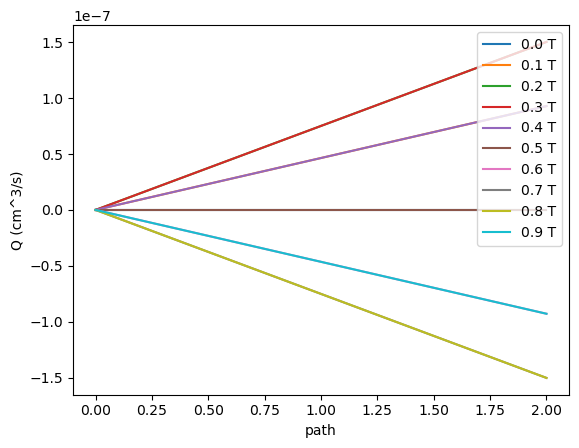

In [219]:
for t in np.arange(0,1,0.1)*T :
    plt.plot(x,np.real(Ftot*np.exp(1j*w*t)),label='%.1f T'%(t/T))
    
plt.xlabel('path')
plt.ylabel('Q (cm^3/s)')

plt.legend()

In [220]:
#arbitrary absisse to visualize pressures
x=[0,1,2]

# pressure branch 1 : (0,1),  (1,2)

P1=np.array([p0,p1,p2])


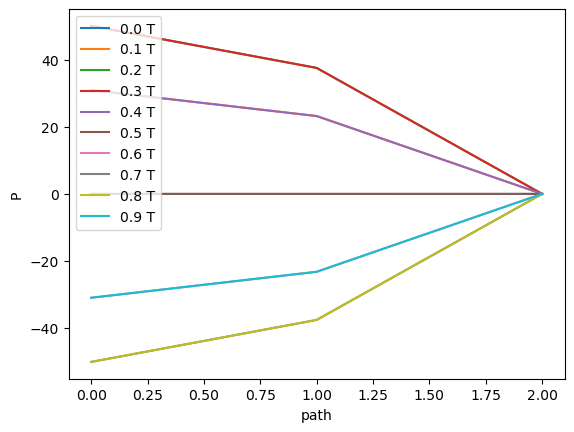

In [221]:
for t in np.arange(0,1,0.1)*T :
    plt.plot(x,np.real(P1*np.exp(1j*w*t)),label='%.1f T'%(t/T))
    
plt.xlabel('path')
plt.ylabel('P')

plt.legend()